# Overlapping phytochemicals (natural products in plants) with approved-drugs (Newman dataset)

### Import modules

In [1]:
from collections import defaultdict
import string

import pandas as pd
from tqdm import tqdm
import seaborn as sns

from rdkit import RDLogger  
from rdkit.Chem.inchi import MolToInchi, InchiToInchiKey
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Descriptors import ExactMolWt

from pubchempy import get_compounds, Compound

import matplotlib as mpl
from matplotlib_venn import venn3, venn2
from matplotlib import pyplot as plt

In [2]:
%config Application.log_level='INFO'
import logging
logging.getLogger('s3fs').setLevel(logging.INFO)
logging.getLogger('botocore').setLevel(logging.INFO)
logging.getLogger('fsspec').setLevel(logging.INFO)

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360

In [4]:
%matplotlib inline

tqdm.pandas()
pd.set_option('display.max_columns', None)

In [5]:
RDLogger.DisableLog('rdApp.*')

In [6]:
def get_first_part_inchikey(inchikey):
    return inchikey.split('-')[0]

Load Newman data

In [7]:
natural_products_df = pd.read_csv(
    's3://enveda-data-kg/others/cdd/newman_natural_products.tsv',
    sep='\t',
    usecols=[
        'curated_name',
        'pubchem_name',
        'pubchem_id',
        'smiles',
    ]
)

synthetics_df = pd.read_csv(
    's3://enveda-data-kg/others/cdd/newman_synthetics.tsv',
    sep='\t',
    usecols=[
        'curated_name',
        'pubchem_name',
        'pubchem_id',
        'smiles',
    ]
)

inchikey_to_pubchem_newman_nps = {}

for pubchem_id, smiles in tqdm(natural_products_df[['pubchem_id', 'smiles']].values):
    inchikey_to_pubchem_newman_nps[
        get_first_part_inchikey(
            InchiToInchiKey(
                MolToInchi(
                    MolFromSmiles(smiles)
    )))] = pubchem_id

100%|██████████| 360/360 [00:00<00:00, 470.08it/s]


In [8]:
natural_products_df.shape, synthetics_df.shape

((360, 4), (927, 4))

In [9]:
synthetics_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,alizapride,6-methoxy-N-[(1-prop-2-enylpyrrolidin-2-yl)met...,135413504,COC1=CC2=C(C=C1C(=O)NCC3CCCN3CC=C)NN=N2
1,amezinium methylsulfate,6-methoxy-1-phenylpyridazin-1-ium-4-amine;meth...,71926,COC1=[N+](N=CC(=C1)N)C2=CC=CC=C2.COS(=O)(=O)[O-]


In [10]:
natural_products_df.head(2)

,curated_name,pubchem_name,pubchem_id,smiles
0,aclarubicin,"methyl (1R,2R,4S)-4-[(2R,4S,5S,6S)-4-(dimethyl...",451415,CC[C@]1(C[C@@H](C2=C(C3=C(C=C2[C@H]1C(=O)OC)C(...
1,Netilmicin sulfate,"(2R,3R,4R,5R)-2-[(1S,2S,3R,4S,6R)-4-amino-3-[[...",62115,CCN[C@@H]1C[C@@H]([C@H]([C@@H]([C@H]1O[C@@H]2[...


In [11]:
smiles_in_data = set(natural_products_df.smiles.unique()).union(
    set(synthetics_df.smiles.unique())
)
len(smiles_in_data)

1268

In [12]:
all_inchikeys = {}
skipped = 0

low_molecular_weights = []

molecular_weights = []

for smiles in tqdm(smiles_in_data):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    mol_weight = ExactMolWt(mol)

    molecular_weights.append(mol_weight)

    if mol_weight < 150:
        low_molecular_weights.append(smiles)
    
    all_inchikeys[get_first_part_inchikey(InchiToInchiKey(MolToInchi(mol)))] = mol

100%|██████████| 1268/1268 [00:01<00:00, 832.32it/s]


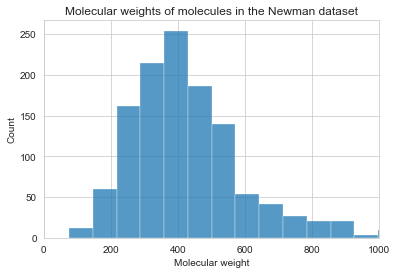

In [13]:
sns.histplot(molecular_weights, bins=100)
plt.title('Molecular weights of molecules in the Newman dataset')
plt.xlabel('Molecular weight')
plt.xlim(0, 1000)
plt.show()

In [14]:
len(all_inchikeys)

1268

This dataset requires an approved license and cant be released by us so this step is not reproducible and the dataset has to be downloaded manually

In [15]:
drugbank_approved_df = PandasTools.LoadSDF(
    '/Users/danieldomingo/Downloads/drugbank_approved.sdf',
    smilesName='SMILES',
    molColName='Molecule',
)

In [16]:
drugbank_approved_df.shape[0]

2587

In [17]:
molecular_weights = []

for smiles in tqdm(drugbank_approved_df.SMILES):
    try:
        mol = MolFromSmiles(smiles)
    except:
        skipped += 1

    molecular_weights.append(ExactMolWt(mol))

100%|██████████| 2587/2587 [00:01<00:00, 2475.66it/s]


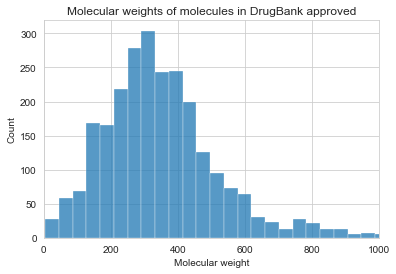

In [18]:
sns.histplot(molecular_weights, bins=100)
plt.title('Molecular weights of molecules in DrugBank approved')
plt.xlabel('Molecular weight')
plt.xlim(0, 1000)
plt.show()

### Load ethnobotanical data

In [19]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
)

medicinal_plants = plant_disease_df.plant_curie.unique()

In [20]:
plant_disease_df.shape[0], len(medicinal_plants)

(97066, 6048)

### Load phytochemical data

In [21]:
# Load Plant to PubChem
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

# Load PubChem to SMILES
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
    
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89271/89271 [00:00<00:00, 345232.69it/s]


In [22]:
len(smiles_to_pubchem), plant_chemical_df.shape[0], len(plant_chemical_df.plant_curie.unique())

(87019, 383591, 19802)

#### InchiKey overlap

In [23]:
pubchem_to_inchikey = {
    pubchem: InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))
    for pubchem, smiles in tqdm(pubchem_to_smiles.items())
}

synthethics_inchikeys_dict = {
    get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))): name
    for name, smiles in tqdm(synthetics_df[['curated_name', 'smiles']].values)
    if smiles not in low_molecular_weights
}

100%|██████████| 927/927 [00:00<00:00, 1250.40it/s]


In [24]:
coconut_smiles = pd.read_csv(
    'https://coconut.naturalproducts.net/download/smiles',
    names=['smiles'],
    header=None,
)

lotus_smiles = pd.read_csv(
    'https://lotus.naturalproducts.net/download/smiles',
    names=['smiles'],
    header=None,
)


In [25]:
natural_products_smiles = set(lotus_smiles.smiles.unique()).union(set(coconut_smiles.smiles.unique()))

In [26]:
len(natural_products_smiles)

683788

In [27]:
all_natural_products_inchikeys = set()

skipped = set()

for smiles in tqdm(natural_products_smiles):
    try:
        mol = MolFromSmiles(smiles)
    except:
        continue
    
    # Skip if there are errors while reading the molecule
    try:
        inchikey = InchiToInchiKey(MolToInchi(mol))
    except:
        skipped.add(smiles)
        continue

    all_natural_products_inchikeys.add(
        get_first_part_inchikey(inchikey)
    )

100%|██████████| 683788/683788 [09:40<00:00, 1177.67it/s]


In [28]:
len(skipped)

351

In [29]:
blacklisted_pubchems = """5281004
31703
451415
262961
5486971
20058
53232
446284
5881
32756
25476
5282381
5281078
4603
444036
54687
10133
4330618
104741
3034010
4739
41774
104838
5362065"""

blacklisted_newman = """51634
5283734
5312153
65157
68921"""

In [30]:
synthethics_inchikeys = {
    inchikey
    for inchikey in synthethics_inchikeys_dict
}

# Get the inchikeys of the natural products that are in LOTUS or COCONUT
natural_products_inchikeys_dict = {
    get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))): name
    for name, smiles in tqdm(natural_products_df[['curated_name', 'smiles']].values)
    if smiles not in low_molecular_weights and get_first_part_inchikey(InchiToInchiKey(MolToInchi(MolFromSmiles(smiles)))) in all_natural_products_inchikeys
}

# List of NPs that are in plants but are not specific to them and shouldnt be counted
blacklisted_inchikeys_plants = {
    get_first_part_inchikey(Compound.from_cid(int(pubchem_id)).inchikey)
    for pubchem_id in blacklisted_pubchems.split('\n')
}

# List of NPs that are in plants but are not specific to them and shouldnt be counted
blacklisted_inchikeys_newman = {
    get_first_part_inchikey(Compound.from_cid(int(pubchem_id)).inchikey)
    for pubchem_id in blacklisted_pubchems.split('\n')
}

natural_products_newman_inchikeys = {
    inchikey
    for inchikey in natural_products_inchikeys_dict
    if inchikey not in blacklisted_inchikeys_newman
}

phytochemicals_inchikey ={
    get_first_part_inchikey(inchikey)
    for inchikey in pubchem_to_inchikey.values()
}

drugbank_inchikeys = {
    get_first_part_inchikey(inchikey)
    for inchikey, mw in drugbank_approved_df[['INCHI_KEY', 'MOLECULAR_WEIGHT']].values
    if float(mw) > 150
}

# Get the ones in the other sets to reduce the number and make a better plot
phytochemicals_inchikey = {
    inchikey
    for inchikey in phytochemicals_inchikey
    if (inchikey in natural_products_newman_inchikeys or inchikey in synthethics_inchikeys) and inchikey not in blacklisted_inchikeys_plants
}

100%|██████████| 360/360 [00:00<00:00, 542.76it/s]


In [31]:
len(synthethics_inchikeys_dict), len(natural_products_inchikeys_dict), len(set(pubchem_to_inchikey.values()))

(915, 189, 86952)

Plot Venn diagrams

In [32]:
# inchikey_to_pubchem = defaultdict(set)

# for pubchem, inchikey in pubchem_to_inchikey.items():
#     inchikey_to_pubchem[get_first_part_inchikey(inchikey)].add(pubchem)

# phytochemicals_pubchems_set = {
#     pubchem
#     for inchikey in phytochemicals_inchikey
#     if inchikey in natural_products_newman_inchikeys
#     for pubchem in inchikey_to_pubchem[inchikey]
# }

# chemical_to_plants = defaultdict(set)

# for plant, chemical in plant_chemical_df.values:
#     chemical_to_plants[chemical].add(plant)

# medicinal_plants_with_approved_drugs = set()
# non_medicinal_plants_with_approved_drugs = set()

# for pubchem in phytochemicals_pubchems_set:

#     if len(chemical_to_plants[pubchem]) >  5:
#         continue

#     for plant in chemical_to_plants[pubchem]:
#         if plant in medicinal_plants:
#             medicinal_plants_with_approved_drugs.add(plant)
#         else:
#             non_medicinal_plants_with_approved_drugs.add(plant)

In [33]:
# len(phytochemicals_pubchems_set)

In [34]:
# len(non_medicinal_plants_with_approved_drugs.union(medicinal_plants_with_approved_drugs))

In [35]:
# print(f"Medicinal plants with approved drugs: {len(medicinal_plants_with_approved_drugs)}")
# print(f"Non-medicinal plants with approved drugs: {len(non_medicinal_plants_with_approved_drugs)}")

In case you want to explore the chemicals

In [36]:
# rows = []

# for inchikey in tqdm(natural_products_newman_inchikeys.difference(
#     {
#         inchikey
#         for inchikey in phytochemicals_inchikey
#         if inchikey in natural_products_newman_inchikeys
#     }
# )):

#     pubchem_id = inchikey_to_pubchem_newman_nps[inchikey]

#     compound = Compound.from_cid(int(pubchem_id))

#     rows.append({
#         'smiles': compound.canonical_smiles,
#         'name': compound.iupac_name,
#         'synonyms': compound.synonyms,
#         'pubchem_id': compound.cid,
#     })
    
# rows = pd.DataFrame(rows)

# rows['Mol Image'] = [Chem.MolFromSmiles(s) for s in rows['smiles']]
# del rows['smiles']

# PandasTools.SaveXlsxFromFrame(rows, 'non_in_plants.xlsx', molCol='Mol Image')

In [37]:
# dump_df = []

# for pubchem in tqdm(
#     medicinal_plants_with_approved_drugs.union(non_medicinal_plants_with_approved_drugs)
# ):
    
#     if (
#         pubchem in medicinal_plants_with_approved_drugs and pubchem not in non_medicinal_plants_with_approved_drugs
#     ):
#         type = 'medicinal'
        
#     elif (
#         pubchem not in medicinal_plants_with_approved_drugs and pubchem in non_medicinal_plants_with_approved_drugs
#     ):
#         type = 'non-medicinal'

#     elif (
#         pubchem in medicinal_plants_with_approved_drugs and pubchem in non_medicinal_plants_with_approved_drugs
#     ):
#         type = 'both'

#     else:
#         raise ValueError('error!')

#     dump_df.append({
#         'name': Compound.from_cid(int(pubchem.split(':')[1])).iupac_name,
#         'synonyms': Compound.from_cid(int(pubchem.split(':')[1])).synonyms,
#         'pubchem_id': int(pubchem.split(':')[1]),
#         '# of plants': len(chemical_to_plants[pubchem]),
#         'plants': '| '.join(chemical_to_plants[pubchem]),
#         'type': type,
#         'smiles': Compound.from_cid(int(pubchem.split(':')[1])).canonical_smiles,
#     })
    
# dump_df = pd.DataFrame(dump_df)

# dump_df['Mol Image'] = [Chem.MolFromSmiles(s) for s in dump_df['smiles']]
# del dump_df['smiles']

# PandasTools.SaveXlsxFromFrame(dump_df, 'double_check_chemicals.xlsx', molCol='Mol Image')

In [38]:
# del phytochemicals_pubchems_set, inchikey_to_pubchem, chemical_to_plants, medicinal_plants_with_approved_drugs, non_medicinal_plants_with_approved_drugs

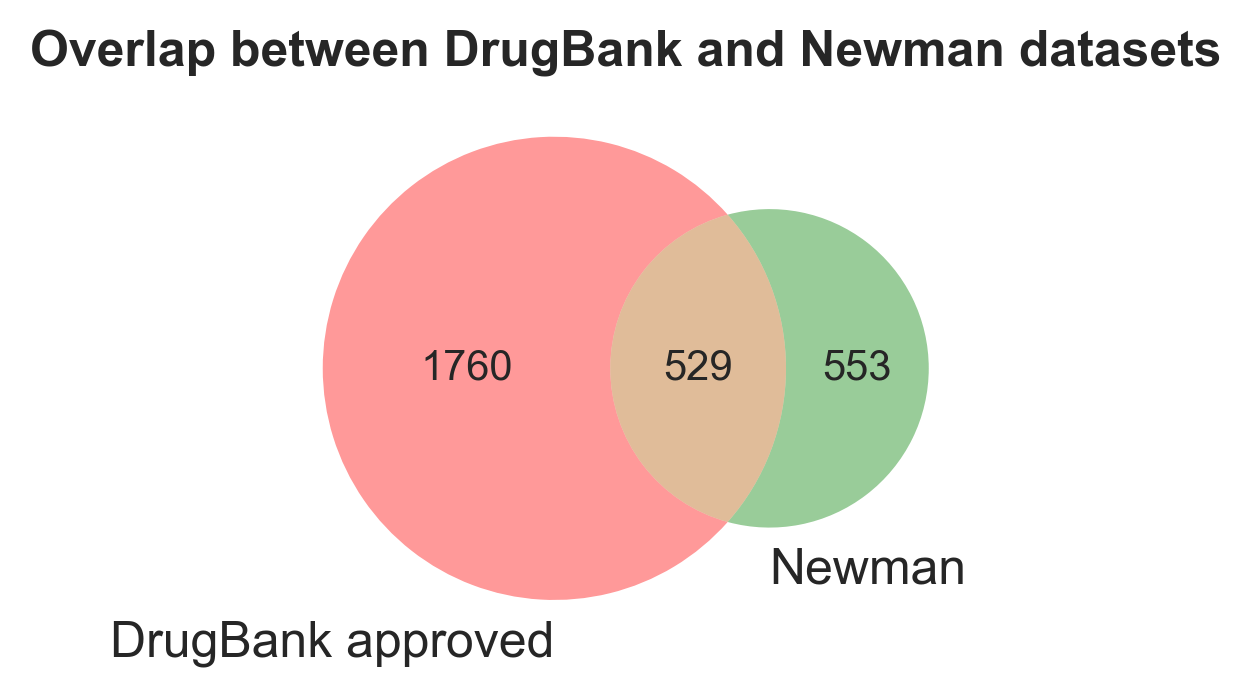

In [39]:
plt.figure(dpi=300, figsize=([3, 3]))
v = venn2([drugbank_inchikeys, synthethics_inchikeys.union(natural_products_newman_inchikeys)], set_labels = ('DrugBank approved', 'Newman')
)
plt.title('Overlap between DrugBank and Newman datasets', fontsize=12, fontweight='bold')

plt.show()

In [40]:
dump_df = pd.DataFrame([
    {
        'type': 'np' if inchikey in natural_products_newman_inchikeys else 'synthetic' if inchikey in synthethics_inchikeys else '-',
        'name': synthethics_inchikeys_dict[inchikey] if inchikey in synthethics_inchikeys_dict else natural_products_inchikeys_dict[inchikey],
        'smiles': get_compounds(inchikey, 'inchikey')[0].canonical_smiles,
    }
    for inchikey in tqdm(natural_products_newman_inchikeys.intersection(phytochemicals_inchikey).union(
        synthethics_inchikeys.intersection(phytochemicals_inchikey)
    ))
])

dump_df['Mol Image'] = [Chem.MolFromSmiles(s) for s in dump_df['smiles']]

PandasTools.SaveXlsxFromFrame(dump_df, 'overlapping_phytochemicals.xlsx', molCol='Mol Image')

100%|██████████| 113/113 [04:41<00:00,  2.49s/it]


### Murcko scaffolds

In [41]:
def get_murcko_scaffolds(smiles, skipped):
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped += 1

    return Chem.MolToSmiles(GetScaffoldForMol(molecule))

synthethics_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(synthetics_df.smiles.values)
    if smiles
}

# Remove the empty ones filtered out before
synthethics_murcko = {
    smiles
    for smiles in synthethics_murcko
    if smiles
}

natural_products_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(natural_products_df.smiles.values)
    if smiles
}

# Remove the empty ones filtered out before
natural_products_murcko = {
    smiles
    for smiles in natural_products_murcko
    if smiles
}

phytochemicals_murcko = {
    get_murcko_scaffolds(smiles, skipped)
    for smiles in tqdm(smiles_to_pubchem.keys())
}

# Get the ones in the other sets to reduce the number and make a better plot
phytochemicals_murcko = {
    murcko
    for murcko in phytochemicals_murcko
    if murcko in synthethics_murcko or murcko in natural_products_murcko
    if murcko
}

# Remove the empty ones filtered out before
phytochemicals_murcko = {
    smiles
    for smiles in phytochemicals_murcko
    if smiles
}

100%|██████████| 87019/87019 [01:11<00:00, 1223.81it/s]


In [42]:
skipped

{'BrC1=CC=C(O)C(=C1)[NH]2C=CC=3C=4C=CC=CC4NC3C2 CNP0471579',
 'BrC1=CN(C=2N=CN=C(N)C12)[CH]3(OC(C)C(O)C3O)C CNP0341841',
 'BrC=1C=C2C(=CC1CC=C(C)C)C3(CCN(C)C3[NH]2O)C(C=C)(C)C CNP0439651',
 'C#NC(C)(CCC=C(C)C)C1CC=C(C)CC1 CNP0182473',
 'C#NC(C=C)(C)CCC=C(C)CCC=C(C)CCC=C(C)C CNP0331844',
 'C#NC1(C)C(C)CC2CC(C)C3CCC(NC)(C)C4CCC1C2C34 CNP0438817',
 'C#NC1(C)CC2C(CC3(C)CC1CC23)C(C)C CNP0018495',
 'C#NC1(C)CCC(=CC2C(C)CCC21)C(C)C CNP0227642',
 'C#NC1(C)CCC(C(=C)CCC=C(C)C)CC1 CNP0017626',
 'C#NC1(C)CCC(C(=CC=CC(C)C)C)CC1 CNP0018727',
 'C#NC1(C)CCC(C(=CCC=C(C)C)C)CC1 CNP0245583',
 'C#NC1(C)CCC(C(C)C)C2C=C(C)CCC21 CNP0018447',
 'C#NC1(C)CCC2C(=CCC(C(C)C)C2C1)C CNP0134444',
 'C#NC1(C)CCC2C(C)CC(C=C(C)C)C3C(=CCC1C32)C CNP0018272',
 'C#NC1(C)CCC2C(C)CC(CC(=C)C)C3C(=C)CCC1C32 CNP0032815',
 'C#NC1(C)CCC2C(C)CC(CC(NC)(C)C)C3C(=C)CCC1C32 CNP0475026',
 'C#NC1(C)CCC2C(C)CC3(C=CC(=C)C)C(C)CCC1C23 CNP0018270',
 'C#NC1(C)CCC2C(C)CC3C=C(C)C(C)C4CCC1C2C34 CNP0040641',
 'C#NC1(C)CCC2C(C)CC3CC(C)(C)CC4=CCC1C2

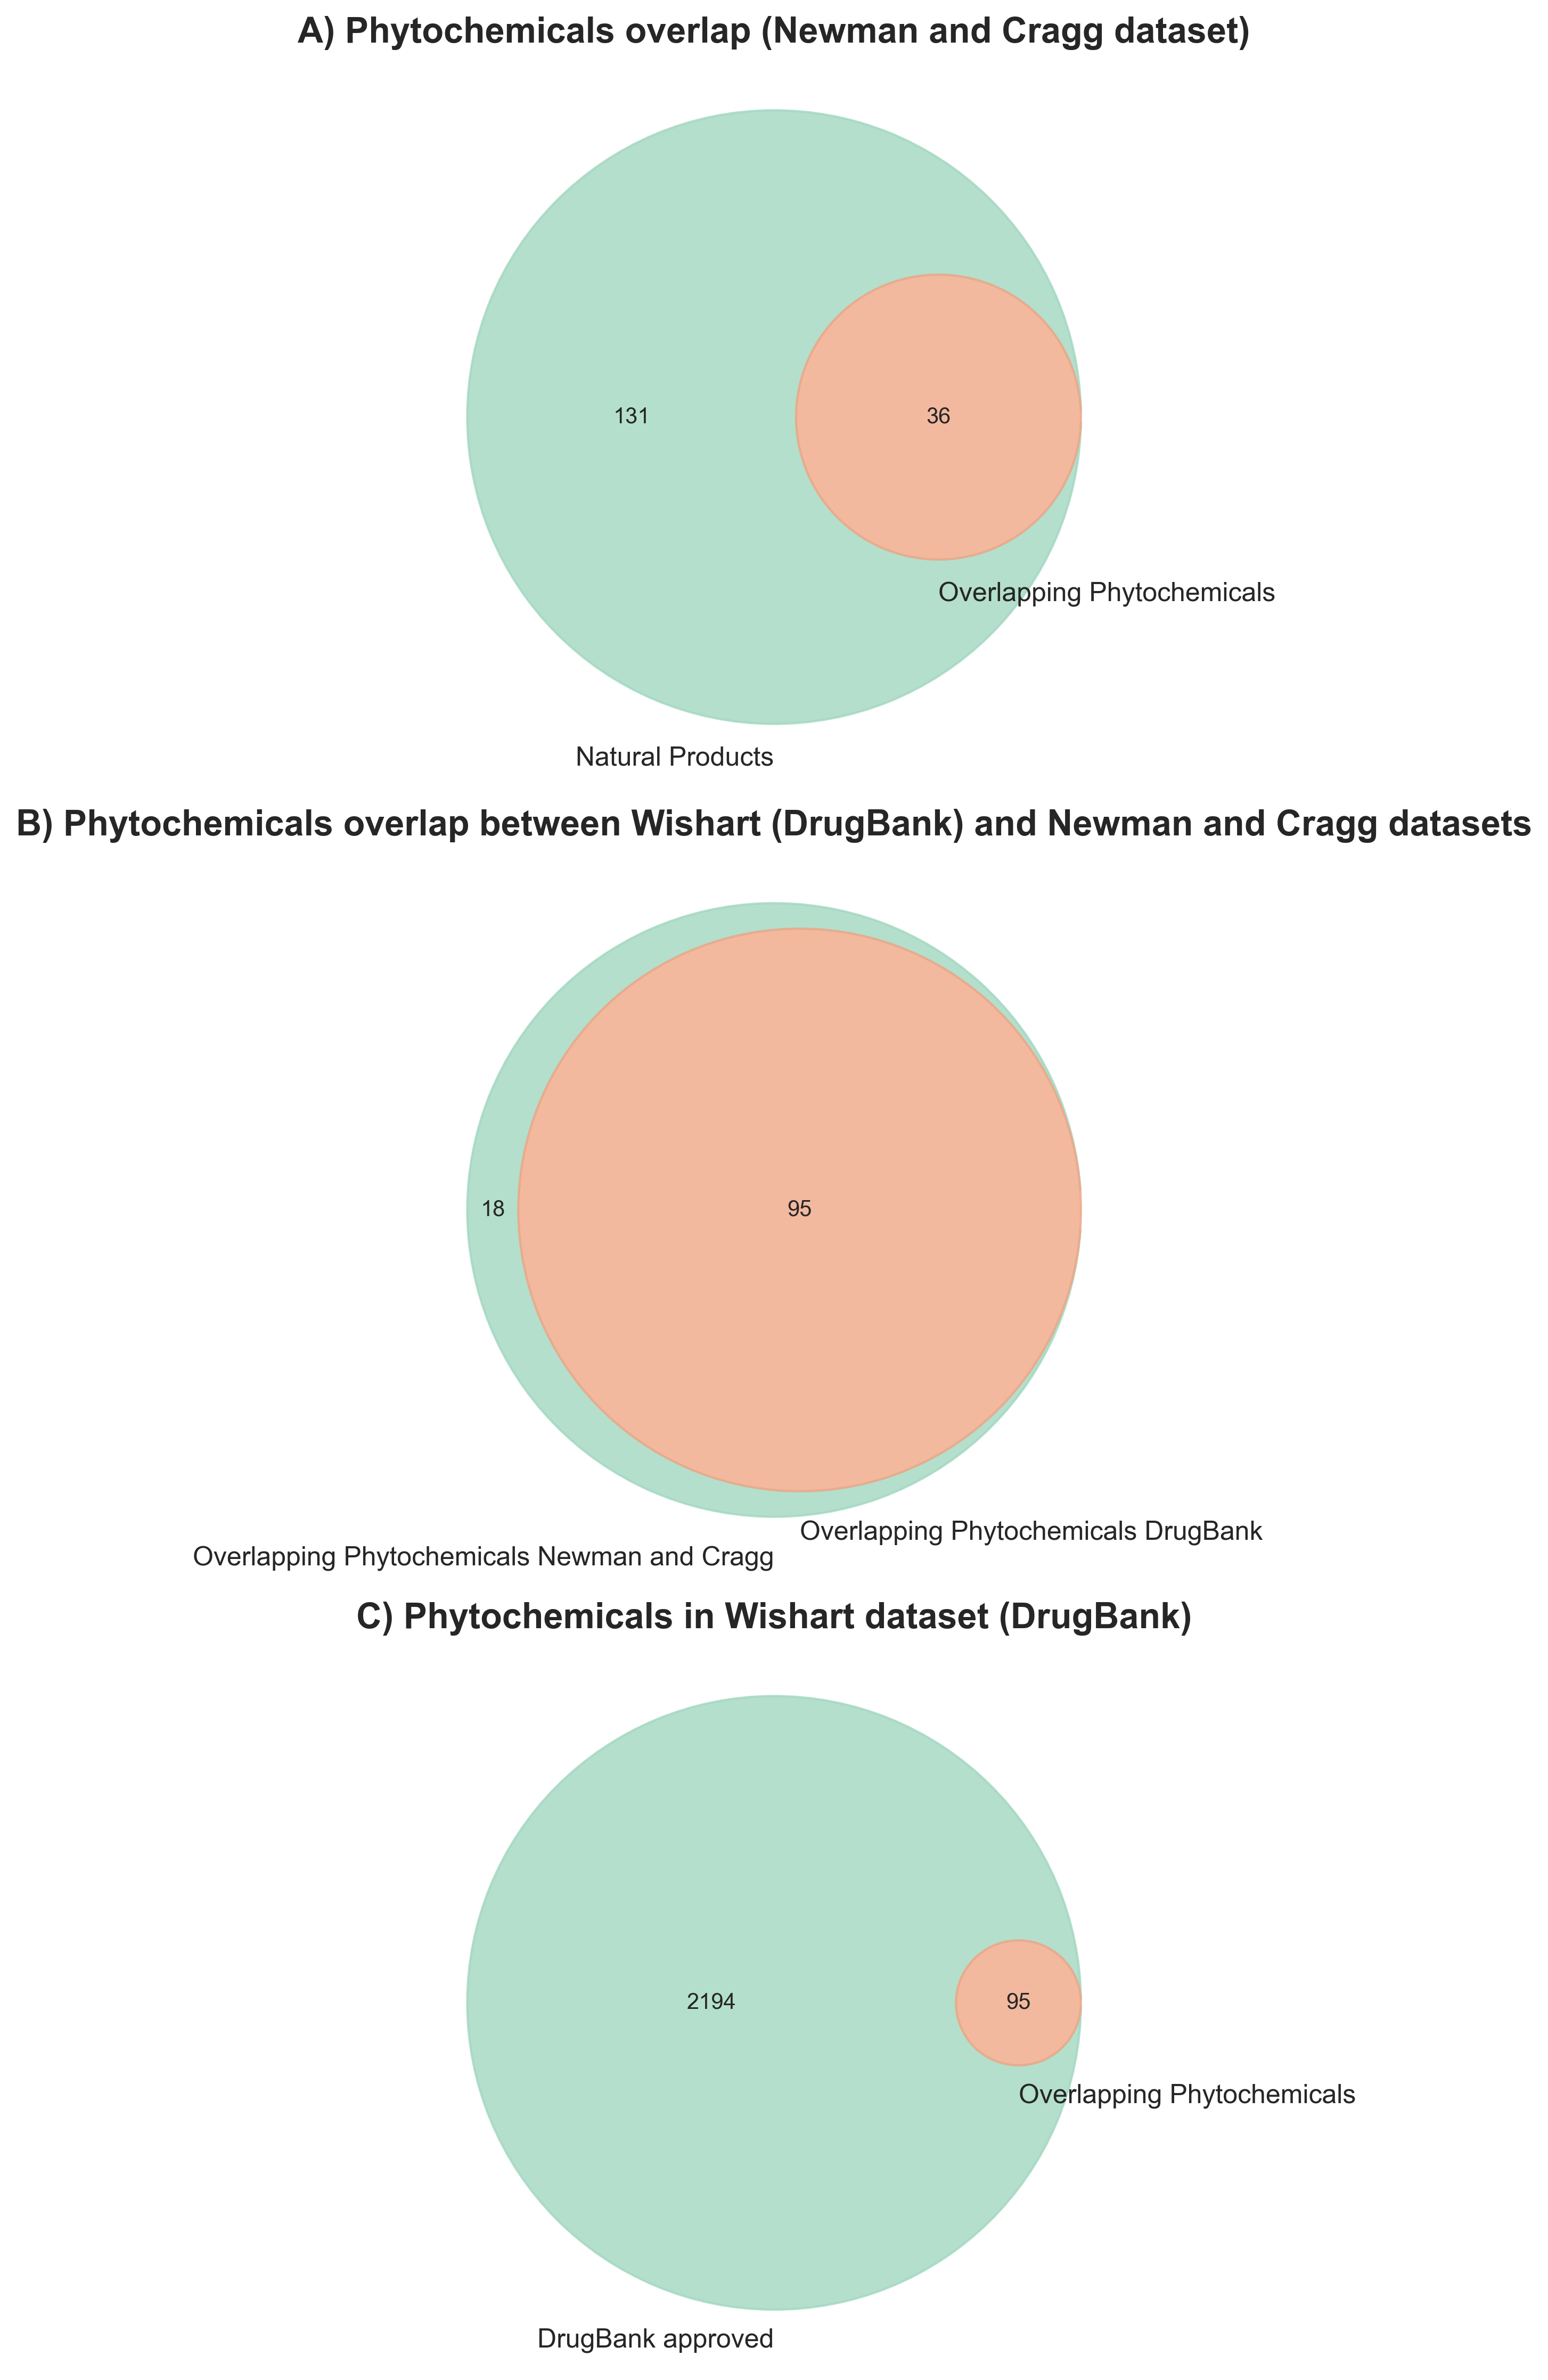

In [71]:
plt.figure(dpi=300, figsize=([15, 15]))

plt.subplots_adjust(wspace=1)

"""Plot 1. Phytochemicals in NP Newman and Cragg"""

plt.subplot(3,1,1)

ax = plt.gca()
v = venn2([
    natural_products_newman_inchikeys, {
        inchikey
        for inchikey in phytochemicals_inchikey
        if inchikey in natural_products_newman_inchikeys
    }
    ], set_labels = ('Natural Products', 'Overlapping Phytochemicals'),
    alpha=.8,
)

plt.title('A) Phytochemicals overlap (Newman and Cragg dataset)', fontweight='bold', fontsize=16)

# Remove the count for phytochemicals that are not in the other sets since we remove that
v.get_label_by_id('01').set_text('')
v.get_patch_by_id('10').set_color('#a2d7c1')
v.get_patch_by_id('11').set_color('#efa888')

"""Plot 2. Newman vs. DrugBank"""
plt.subplot(3,1,2)

v = venn2(
    [
    phytochemicals_inchikey, {
        inchikey
        for inchikey in phytochemicals_inchikey
        if inchikey in drugbank_inchikeys
    }],
    set_labels = ('Overlapping Phytochemicals Newman and Cragg', 'Overlapping Phytochemicals DrugBank'),
    alpha=.8,
)
v.get_label_by_id('01').set_text('')
v.get_patch_by_id('10').set_color('#a2d7c1')
v.get_patch_by_id('11').set_color('#efa888')

plt.title('B) Phytochemicals overlap between Wishart (DrugBank) and Newman and Cragg datasets', fontweight='bold', fontsize=16)

"""Plot 3. Phytochemicals overlapping in the two datasets"""
plt.subplot(3,1,3)
v = venn2([drugbank_inchikeys, {
        inchikey
        for inchikey in phytochemicals_inchikey
        if inchikey in drugbank_inchikeys
    }], set_labels = ('DrugBank approved', 'Overlapping Phytochemicals'),
    alpha=.8,
)
# plt.title('Phytochemicals that are approved-drugs on the DrugBank dataset', fontsize=10, fontweight='bold')
v.get_label_by_id('010').set_text('')
v.get_patch_by_id('10').set_color('#a2d7c1')
v.get_patch_by_id('11').set_color('#efa888')


plt.title('C) Phytochemicals in Wishart dataset (DrugBank)', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.savefig(f'supplementary_figure_approved_drugs_phytochemicals.png', bbox_inches='tight')
plt.show()

Scaffolds in all the three sets

In [44]:
# Chem.Draw.MolsToGridImage(
#     [
#         MolFromSmiles(smiles)
#         for smiles in synthethics_murcko.intersection(natural_products_murcko).intersection(phytochemicals_murcko)
#         if smiles
#     ],
#     molsPerRow=4,
#     subImgSize=(200,200),
# )    

Scaffolds in NPs overlapping with phytochemicals

In [45]:
# Chem.Draw.MolsToGridImage(
#     [
#         MolFromSmiles(smiles)
#         for smiles in natural_products_murcko.intersection(phytochemicals_murcko)
#         if smiles
#     ],
#     molsPerRow=8,
#     subImgSize=(200,200),
# )

Scaffolds in Synthetics subset overlapping with phytochemicals

In [68]:
# Chem.Draw.MolsToGridImage(
#     [
#         MolFromSmiles(smiles)
#         for smiles in synthethics_murcko.intersection(phytochemicals_murcko)
#         if smiles
#     ],
#     molsPerRow=8,
#     subImgSize=(200,200),
#     maxMols=100,
# )